In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import re

In [2]:
arg_component_balance=False
arg_add_new_dataset=False
arg_add_transformer=True

In [3]:
meta_feature_flag='whole_subseries_delta'
result_path = f'/data/nishome/user1/minqi/TSGym/meta_cc/result_{meta_feature_flag}'
# datasets = ['ETTh1', 'ETTh2', 'ETTm1', 'ETTm2', 'ili', 'weather', 'ECL', 'Exchange', 'traffic']
datasets = ['ETTh1', 'ETTh2', 'ETTm1', 'ETTm2', 'ili', 'weather', 'Exchange']
if arg_add_new_dataset:
    datasets.extend(['covid-19', 'fred-md'])
file_list = [f'{dataset}-component_balance_{arg_component_balance}-add_new_dataset_{arg_add_new_dataset}-add_transformer_{arg_add_transformer}.npz' for dataset in datasets]

baselines = [
 'iTransformer',
 'MambaSimple',
 'PatchTST',
 'TimeMixer',
 'Koopa',
 'SegRNN',
 'DLinear',
 'FEDformer',
 'Crossformer',
 'Informer',
 'PAttn',
 'ETSformer',
 'TimeXer',
 'LightTS',
 'Nonstationary',
 'TiDE',
 'Pyraformer',
 'MICN',
 'Transformer',
 'FiLM',
 'TimesNet',
 'TSMixer',
 'Autoformer',
 'Reformer',
 'DUET']
print(len(file_list))

7


In [4]:
# sota performance
def search_sota_performance(dataset, pred_lens=[96],
                            path_old='/data/nishome/user1/minqi/TSGym/results', 
                            path='/data/nishome/user1/minqi/TSGym/results_long_term_forecasting/results'):
    result_dict = {}
    for pred_len in pred_lens:
        model_list_old = os.listdir(path_old)
        model_list_old = [_ for _ in model_list_old if f'pl{pred_len}' in _ and dataset in _]
        try:
            model_list_new = os.listdir(os.path.join(path, dataset))
            model_list_new = [_ for _ in model_list_new if f'pl{pred_len}' in _]
        except:
            model_list_new = []
        model_list = model_list_old + model_list_new

        result_dict[pred_len] = {}
        for model in model_list:
            try:
                result = np.load(os.path.join(path_old, model, 'metrics.npy'), allow_pickle=True)
            except:
                result = np.load(os.path.join(path, dataset, model, 'metrics.npy'), allow_pickle=True)
            result_dict[pred_len][model] = result[1]
    df = pd.DataFrame.from_dict(result_dict[pred_lens[0]], orient='index')
    df.columns = ['mse']
    df = df.sort_values(by='mse')
    df.index = [_.split('_')[6] for _ in df.index]

    return df

In [5]:
# sota performance
def search_sota_performance(dataset, pred_lens=[96],
                            path_old='/data/nishome/user1/minqi/TSGym/results', 
                            path='/data/nishome/user1/minqi/TSGym/results_long_term_forecasting/results'):
    result_dict = {}
    for pred_len in pred_lens:
        model_list_old = os.listdir(path_old)
        model_list_old = [_ for _ in model_list_old if f'pl{pred_len}' in _ and dataset in _]

        try:
            model_list_new = os.listdir(os.path.join(path, dataset))
            model_list_new = [_ for _ in model_list_new if f'pl{pred_len}' in _]
        except:
            model_list_new = []
        model_list = model_list_old + model_list_new

        result_dict[pred_len] = {}
        for model in model_list:
            try:
                result = np.load(os.path.join(path_old, model, 'metrics.npy'), allow_pickle=True)
            except:
                result = np.load(os.path.join(path, dataset, model, 'metrics.npy'), allow_pickle=True)
            result_dict[pred_len][model] = result[1]

    df = pd.DataFrame.from_dict(result_dict[pred_lens[0]], orient='index')
    df.columns = ['mse']
    df = df.sort_values(by='mse')
    df.index = [_.split('_')[1] if 'LTF' in _ or 'STF' in _ else _.split('_')[6] for _ in df.index]

    return df

In [6]:
dfs_rank = []; dfs_dict = {}
for pred_len_1, pred_len_2 in zip([96, 192, 336, 720], [24, 36, 48, 60]):
    file_list = [f'{dataset}-component_balance_{arg_component_balance}-add_new_dataset_{arg_add_new_dataset}-add_transformer_{arg_add_transformer}_{pred_len_1}_{pred_len_2}.npz' for dataset in datasets]
    dfs = []
    for i, file in enumerate(file_list):
        # dataset = file.split('-')[0]
        dataset = file[:re.search('-component', file).start()]

        if dataset in ['ili', 'covid-19', 'fred-md']:
            df = search_sota_performance(dataset, pred_lens=[pred_len_2])
        else:
            df = search_sota_performance(dataset, pred_lens=[pred_len_1])

        # 添加图例和标题
        perf_epoch = np.load(os.path.join(result_path, file), allow_pickle=True)
        top1_perf_epoch = perf_epoch['top1_perf_epoch']

        df.loc['TSGym'] = top1_perf_epoch[perf_epoch['best_epoch'].item()]
        df.dropna(inplace=True)
        df = df.sort_values(by='mse')
        df = df.reset_index()
        df.columns = ['model', dataset]
        # todo: 有重复, 并且跑出来结果还不同
        df = df.drop_duplicates(subset='model', keep='first')
        df = df.set_index('model')
        dfs.append(df)

    dfs = pd.concat(dfs, axis=1)
    dfs_dict[pred_len_1] = dfs

baselines = pd.concat(list({k: v.rename(columns=lambda col: f"{col}_{k}") for k, v in dfs_dict.items()}.values()), axis=1).dropna().index
baselines = list(baselines)
print(baselines)

['DUET', 'SegRNN', 'TSGym', 'MICN', 'Crossformer', 'Autoformer', 'TSMixer', 'Pyraformer', 'Transformer']


In [7]:
# TSGym vs best sota
dfs_rank = []; dfs_dict = {}
for pred_len_1, pred_len_2 in zip([96, 192, 336, 720], [24, 36, 48, 60]):
    file_list = [f'{dataset}-component_balance_{arg_component_balance}-add_new_dataset_{arg_add_new_dataset}-add_transformer_{arg_add_transformer}_{pred_len_1}_{pred_len_2}.npz' for dataset in datasets]
    dfs = []
    for i, file in enumerate(file_list):
        # dataset = file.split('-')[0]
        dataset = file[:re.search('-component', file).start()]

        if dataset in ['ili', 'covid-19', 'fred-md']:
            df = search_sota_performance(dataset, pred_lens=[pred_len_2])
        else:
            df = search_sota_performance(dataset, pred_lens=[pred_len_1])

        # 添加图例和标题
        perf_epoch = np.load(os.path.join(result_path, file), allow_pickle=True)
        top1_perf_epoch = perf_epoch['top1_perf_epoch']

        df.loc['TSGym'] = top1_perf_epoch[perf_epoch['best_epoch'].item()]
        df.dropna(inplace=True)
        df = df.loc[baselines]
        df = df.sort_values(by='mse')
        df = df.reset_index()
        df.columns = ['model', dataset]
        # todo: 有重复, 并且跑出来结果还不同
        df = df.drop_duplicates(subset='model', keep='first')
        df = df.set_index('model')
        dfs.append(df)

    model_names = set.intersection(*map(set, [_.index.tolist() for _ in dfs]))
    for i, df in enumerate(dfs):
        df = df[[_ in model_names for _ in df.index]]
        dfs[i] = df.sort_values(by=df.columns[0])

    ranks = {k: [] for k in baselines}
    ranks['TSGym'] = []
    for df in dfs:
        for baseline in baselines:
            if len(np.where(df.index == baseline)[0]) > 0:
                ranks[baseline].append((np.where(df.index == baseline)[0] + 1).item())
        ranks['TSGym'].append((np.where(df.index == 'TSGym')[0] + 1).item())

    dfs = pd.concat(dfs, axis=1)
    dfs = dfs.round(4)
    dfs.index = dfs.index.str.replace('TemporalFusionTransformer', 'TFT')
    dfs_dict[pred_len_1] = dfs
    # dfs.to_excel(f'./meta/results_paper/perf_component_balance_{arg_component_balance}-add_new_dataset_{arg_add_new_dataset}-add_transformer_{arg_add_transformer}_{pred_len_1}_{pred_len_2}.xlsx', index=True)
    
    df_rank = pd.Series({k: np.mean(v) for k,v in ranks.items() if len(v) > 0})
    df_rank = df_rank.sort_values()
    dfs_rank.append(df_rank)

dfs_rank = pd.concat(dfs_rank, axis=1)
dfs_rank.columns = [str(_) for _ in [96, 192, 336, 720]]
dfs_rank.index = dfs_rank.index.str.replace('TemporalFusionTransformer', 'TFT')
dfs_rank = dfs_rank.round(2)
# dfs_rank.to_excel(f'./meta/results_paper/rank_component_balance_{arg_component_balance}-add_new_dataset_{arg_add_new_dataset}-add_transformer_{arg_add_transformer}.xlsx', index=True)

In [8]:
dfs_rank

,96,192,336,720
DUET,1.57,3.00,2.86,2.86
TSGym,1.86,1.43,1.86,1.86
SegRNN,3.00,2.57,3.00,3.43
MICN,4.00,4.00,3.86,4.43
Crossformer,5.57,5.86,5.86,6.86
Autoformer,6.29,5.43,5.00,4.71
TSMixer,6.43,6.29,6.00,5.00
Pyraformer,8.00,8.00,8.00,7.57
Transformer,8.29,8.43,8.57,8.29


In [9]:
dfs

,ETTh1,ETTh2,ETTm1,ETTm2,ili,weather,Exchange
model,,,,,,,
SegRNN,0.4486,0.4228,0.4535,0.3873,4.5968,0.3564,1.0145
TSGym,0.4950,0.4090,0.4134,0.3598,2.5665,0.3322,0.9833
DUET,0.5339,0.4288,0.5056,0.4346,2.2497,0.3478,0.7333
Autoformer,0.5396,0.4838,0.5238,0.4340,2.8931,0.4442,1.1266
Crossformer,0.7193,3.0893,0.7415,5.0979,4.5640,0.3616,1.6477
TSMixer,0.7384,2.4228,0.6059,2.4974,6.4026,0.3165,0.5829
MICN,0.8083,0.8366,0.4953,0.5111,2.9754,0.3505,0.7933
Pyraformer,0.9673,4.1336,0.8452,3.9508,4.5446,0.3878,1.8688
Transformer,1.0015,2.7661,1.0352,3.1472,5.0720,0.9157,2.1655


In [7]:
fig = plt.figure(figsize=(15, 9))
for i, file in enumerate(file_list):
    try:
        perf_epoch = np.load(os.path.join(result_path, file), allow_pickle=True)
        # print(perf_epoch.files)
        fig.add_subplot(4, 3, i+1)
        for _ in perf_epoch.files:
            if _ in ['pred_ranks_for_true_topk_epoch', 'true_ranks_for_pred_topk_epoch']:
                plt.plot(perf_epoch[_], label=_)
            elif _ == 'total_num':
                plt.title(f'{file.replace(".npz", "").split("-")[0]}-total_num: {perf_epoch[_]}')
            elif _ == 'best_epoch':
                plt.axvline(perf_epoch['best_epoch'].item(), color='black', linestyle='--')
            else:
                pass 

        if i==0: plt.legend()
    except:
        continue

plt.subplots_adjust(wspace=0.3, hspace=0.4)
plt.show()

<Figure size 1500x900 with 0 Axes>

In [8]:
fig = plt.figure(figsize=(12, 20))
for i, file in enumerate(file_list):
    try:
        dataset = file[:re.search('-component', file).start()]
        if dataset in ['ili', 'covid-19', 'fred-md']:
            df = search_sota_performance(dataset, pred_lens=[24])
        else:
            df = search_sota_performance(dataset)
        # except:
        #     continue
        fig.add_subplot(4, 3, i+1)
        for model, metric in df.iterrows():
            plt.axhline(y=metric.item(), color='blue', linestyle='--')
            plt.text(0, metric.item(), model, color='black')

        # 添加图例和标题
        perf_epoch = np.load(os.path.join(result_path, file), allow_pickle=True)
        top1_perf_epoch = perf_epoch['top1_perf_epoch']
        plt.plot(top1_perf_epoch, color='orange', label='TSGym')

        plt.legend()
        plt.title(f'TSGym vs SOTA, Dataset: {dataset}')
    except:
        continue

plt.show()

<Figure size 1200x2000 with 0 Axes>

In [9]:
# TSGym vs best sota
dfs = []
ranks = {k: [] for k in baselines}
ranks['TSGym'] = []
for i, file in enumerate(file_list):
    # dataset = file.split('-')[0]
    dataset = file[:re.search('-component', file).start()]

    if dataset in ['ili', 'covid-19', 'fred-md']:
        df = search_sota_performance(dataset, pred_lens=[24])
    else:
        df = search_sota_performance(dataset)

    # 添加图例和标题
    perf_epoch = np.load(os.path.join(result_path, file), allow_pickle=True)
    top1_perf_epoch = perf_epoch['top1_perf_epoch']


    df.loc['TSGym'] = top1_perf_epoch[perf_epoch['best_epoch'].item()]
    df = df.sort_values(by='mse')
    df = df.reset_index()
    df.columns = ['model', dataset]
    # todo: 有重复, 并且跑出来结果还不同
    df = df.drop_duplicates(subset='model', keep='first')
    for baseline in baselines:
        if len(np.where(df['model'] == baseline)[0]) > 0:
            ranks[baseline].append((np.where(df['model'] == baseline)[0] + 1).item())
    ranks['TSGym'].append((np.where(df['model'] == 'TSGym')[0] + 1).item())
    dfs.append(df)

dfs = pd.concat(dfs, axis=1)
dfs

ValueError: Length mismatch: Expected axis has 0 elements, new values have 1 elements

In [39]:
ranks

{'iTransformer': [7, 7, 7, 6],
 'MambaSimple': [21, 23, 27, 19],
 'PatchTST': [3, 5, 2, 9, 4, 3],
 'TimeMixer': [4, 4, 23, 2],
 'Koopa': [12, 8, 4, 7],
 'SegRNN': [2, 1, 15, 8],
 'DLinear': [9, 12, 22, 10, 11, 14],
 'FEDformer': [11, 13, 11, 19, 8],
 'Crossformer': [16, 24, 14, 24, 21],
 'Informer': [29, 29, 24, 27, 16],
 'PAttn': [8, 6, 5, 7, 3, 4],
 'ETSformer': [24, 17, 19, 14, 18],
 'TimeXer': [5, 2, 9, 5],
 'LightTS': [19, 18, 29, 12, 17, 11],
 'Nonstationary': [23, 20, 8, 3, 16, 10],
 'TiDE': [6, 10, 26, 13, 9, 17],
 'Pyraformer': [26, 26, 21, 14, 26, 13],
 'MICN': [15, 16, 13, 2, 10, 5],
 'Transformer': [27, 28, 20, 25],
 'FiLM': [14, 9, 17, 21],
 'TimesNet': [17, 11, 3, 4, 15, 9],
 'TSMixer': [22, 25, 25, 22],
 'Autoformer': [18, 19, 16, 11, 18, 12],
 'Reformer': [28, 27, 18, 28, 15],
 'DUET': [1, 3, 10, 1, 1],
 'TSGym': [13, 21, 6, 1, 23, 2]}

In [40]:
{k: np.mean(v) for k,v in ranks.items() if len(v) > 0}

{'iTransformer': 6.75,
 'MambaSimple': 22.5,
 'PatchTST': 4.333333333333333,
 'TimeMixer': 8.25,
 'Koopa': 7.75,
 'SegRNN': 6.5,
 'DLinear': 13.0,
 'FEDformer': 12.4,
 'Crossformer': 19.8,
 'Informer': 25.0,
 'PAttn': 5.5,
 'ETSformer': 18.4,
 'TimeXer': 5.25,
 'LightTS': 17.666666666666668,
 'Nonstationary': 13.333333333333334,
 'TiDE': 13.5,
 'Pyraformer': 21.0,
 'MICN': 10.166666666666666,
 'Transformer': 25.0,
 'FiLM': 15.25,
 'TimesNet': 9.833333333333334,
 'TSMixer': 23.5,
 'Autoformer': 15.666666666666666,
 'Reformer': 23.2,
 'DUET': 3.2,
 'TSGym': 11.0}

In [12]:
# TSGym vs best sota
dfs_rank = []
for pred_len_1, pred_len_2 in zip([96, 192, 336, 720], [24, 36, 48, 60]):
    file_list = [f'result_whole_subseries_delta_{pred_len_1}/{dataset}-component_balance_{arg_component_balance}-add_new_dataset_{arg_add_new_dataset}-add_transformer_{arg_add_transformer}.npz' for dataset in datasets]
    dfs = []
    for i, file in enumerate(file_list):
        # dataset = file.split('-')[0]
        dataset = file.split('/')[-1].split('-')[0]
        print(dataset)

        if dataset in ['ili', 'covid-19', 'fred-md']:
            df = search_sota_performance(dataset, pred_lens=[pred_len_2])
        else:
            df = search_sota_performance(dataset, pred_lens=[pred_len_1])

        perf_epoch = np.load(file, allow_pickle=True)
        top1_perf_epoch = perf_epoch['top1_perf_epoch']

        df.loc['TSGym'] = top1_perf_epoch[perf_epoch['best_epoch'].item()]
        df.dropna(inplace=True)
        df = df.sort_values(by='mse')
        df = df.reset_index()
        df.columns = ['model', dataset]
        # todo: 有重复, 并且跑出来结果还不同
        df = df.drop_duplicates(subset='model', keep='first')
        df = df.set_index('model')
        dfs.append(df)

    model_names = set.intersection(*map(set, [_.index.tolist() for _ in dfs]))
    for i, df in enumerate(dfs):
        df = df[[_ in model_names for _ in df.index]]
        dfs[i] = df.sort_values(by=df.columns[0])

    ranks = {k: [] for k in baselines}
    ranks['TSGym'] = []
    for df in dfs:
        for baseline in baselines:
            if len(np.where(df.index == baseline)[0]) > 0:
                ranks[baseline].append((np.where(df.index == baseline)[0] + 1).item())
        ranks['TSGym'].append((np.where(df.index == 'TSGym')[0] + 1).item())

    dfs = pd.concat(dfs, axis=1)
    dfs = dfs.round(4)
    dfs.index = dfs.index.str.replace('TemporalFusionTransformer', 'TFT')
    # dfs.to_excel(f'./meta/perf_component_balance_{arg_component_balance}-add_new_dataset_{arg_add_new_dataset}-add_transformer_{arg_add_transformer}_{pred_len_1}_{pred_len_2}.xlsx', index=True)
    
    df_rank = pd.Series({k: np.mean(v) for k,v in ranks.items() if len(v) > 0})
    df_rank = df_rank.sort_values()
    dfs_rank.append(df_rank)

dfs_rank = pd.concat(dfs_rank, axis=1)
dfs_rank.columns = [str(_) for _ in [96, 192, 336, 720]]
dfs_rank.index = dfs_rank.index.str.replace('TemporalFusionTransformer', 'TFT')
dfs_rank = dfs_rank.round(2)
# dfs_rank.to_excel(f'./meta/rank_component_balance_{arg_component_balance}-add_new_dataset_{arg_add_new_dataset}-add_transformer_{arg_add_transformer}.xlsx', index=True)

ETTh1
{96: {'long_term_forecast_ETTh1_96_96_TimesNet_ETTh1_ftM_sl96_ll48_pl96_dm16_nh8_el2_dl1_df32_expand2_dc4_fc3_ebtimeF_dtTrue_Exp_epochs10_lr0.0001_lrstype1_0': 0.42050448, 'long_term_forecast_ETTh1_96_96_PAttn_ETTh1_ftM_sl96_ll48_pl96_dm512_nh2_el2_dl1_df2048_expand2_dc4_fc3_ebtimeF_dtTrue_Exp_epochs10_lr0.0001_lrstype1_0': 0.39119545, 'long_term_forecast_ETTh1_96_96_Crossformer_ETTh1_ftM_sl96_ll48_pl96_dm512_nh8_el2_dl1_df2048_expand2_dc4_fc3_ebtimeF_dtTrue_Exp_epochs10_lr0.0001_lrstype1_0': 0.41335097, 'long_term_forecast_ETTh1_96_96_LightTS_ETTh1_ftM_sl96_ll48_pl96_dm512_nh8_el2_dl1_df2048_expand2_dc4_fc3_ebtimeF_dtTrue_Exp_epochs10_lr0.0001_lrstype1_0': 0.44893518, 'long_term_forecast_ETTh1_96_96_FEDformer_ETTh1_ftM_sl96_ll48_pl96_dm512_nh8_el2_dl1_df2048_expand2_dc4_fc3_ebtimeF_dtTrue_Exp_epochs10_lr0.0001_lrstype1_0': 0.40184787, 'long_term_forecast_ETTh1_96_96_Autoformer_ETTh1_ftM_sl96_ll48_pl96_dm512_nh8_el2_dl1_df2048_expand2_dc4_fc3_ebtimeF_dtTrue_Exp_epochs10_lr0.0001_

In [13]:
dfs_rank

,96,192,336,720
TSGym,2.00,1.50,1.17,1.17
PatchTST,3.17,1.83,NaN,NaN
PAttn,3.67,NaN,NaN,NaN
MICN,5.83,3.00,2.17,NaN
TimesNet,6.00,NaN,NaN,NaN
TiDE,8.17,NaN,NaN,NaN
DLinear,8.33,NaN,NaN,NaN
Nonstationary,8.50,NaN,NaN,NaN
Autoformer,10.33,3.67,2.67,1.83
LightTS,11.00,NaN,NaN,NaN


meta-feature的差异性

In [11]:
# meta_feature_path = '/data/coding/chaochuan/TSGym/meta_learner_cc/meta_feature_copy/meta_feature'

In [12]:
# meta_features_dict = {}
# for file in os.listdir(meta_feature_path):
#     if file.endswith('.npz'):
#         meta_feature = np.load(os.path.join(meta_feature_path, file), allow_pickle=True)
#         meta_features_dict[file.replace('.npz', '').replace('meta_feature_', '')] = meta_feature['meta_feature']

In [13]:
# meta_features = np.stack(list(meta_features_dict.values()))
# meta_features = np.clip(meta_features, -1e4, 1e4)

# # z-score
# mu = np.nanmean(meta_features, axis=0, keepdims=True)
# std = np.nanstd(meta_features, axis=0, keepdims=True)

# meta_features = (meta_features - mu) / (std + 1e-6)
# meta_features = np.nan_to_num(meta_features, nan=0.0)

In [14]:
# fig = plt.figure(figsize=(20, 20))

# for seed in range(1, 5):
#     tsne = TSNE(n_components=2, random_state=seed, perplexity=10)
#     meta_features_tsne = tsne.fit_transform(meta_features) 
#     meta_features_dict_tsne = {k: v for k, v in zip(meta_features_dict.keys(), meta_features_tsne)}
#     fig.add_subplot(2, 2, seed)
#     for k, v in meta_features_dict_tsne.items():
#         plt.scatter(v[0], v[1])
#         plt.text(v[0], v[1], k, fontsize=12)
# fig.suptitle('TSNE', fontsize=16)
# plt.show()


In [15]:
# fig = plt.figure(figsize=(20, 20))

# pca = PCA(n_components=2, random_state=42)
# meta_features_pca = pca.fit_transform(meta_features) 
# meta_features_dict_pca = {k: v for k, v in zip(meta_features_dict.keys(), meta_features_pca)}
# for k, v in meta_features_dict_pca.items():
#     plt.scatter(v[0], v[1])
#     plt.text(v[0], v[1], k, fontsize=16)
# plt.title('PCA', fontsize=16)
# plt.show()


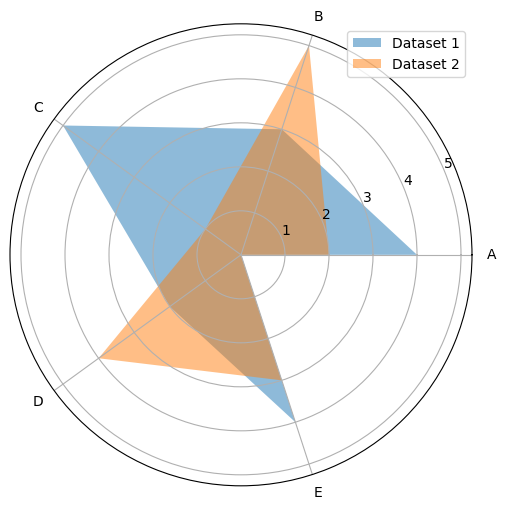

In [79]:
import matplotlib.pyplot as plt
import numpy as np
 
# 数据准备
categories = ['A', 'B', 'C', 'D', 'E']
# 数据准备
values1 = [4, 3, 5, 2, 4]
values2 = [2, 5, 1, 4, 3]
 
# 绘制堆叠雷达图
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
ax.fill_between(np.linspace(0, 2 * np.pi, len(categories), endpoint=False), values1, alpha=0.5, label='Dataset 1')
ax.fill_between(np.linspace(0, 2 * np.pi, len(categories), endpoint=False), values2, alpha=0.5, label='Dataset 2')
ax.set_xticks(np.linspace(0, 2 * np.pi, len(categories), endpoint=False))
ax.set_xticklabels(categories)
ax.legend()
 
plt.show()

/data/nishome/user1/miniconda3/envs/mqenv/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 22534 (\N{CJK UNIFIED IDEOGRAPH-5806}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/data/nishome/user1/miniconda3/envs/mqenv/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 21472 (\N{CJK UNIFIED IDEOGRAPH-53E0}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


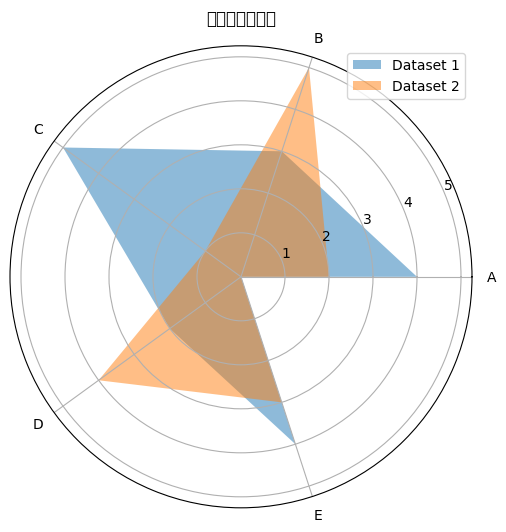

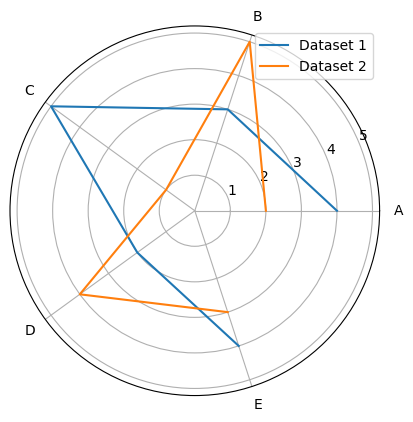

In [75]:
# 数据准备
matrix_values = np.array([[4, 3, 5, 2, 4], [2, 5, 1, 4, 3]])
 
# 绘制矩阵雷达图
fig, ax = plt.subplots(subplot_kw=dict(polar=True))
for i in range(len(matrix_values)):
    ax.plot(np.linspace(0, 2 * np.pi, len(categories), endpoint=False), matrix_values[i], label=f'Dataset {i + 1}')
 
ax.set_xticks(np.linspace(0, 2 * np.pi, len(categories), endpoint=False))
ax.set_xticklabels(categories)
ax.legend()
 
plt.show()